# Mini-Challenge!


In the previous tutorials, we've explored the possibilities given both [Theano](http://deeplearning.net/software/theano/) and [Keras](https://keras.io/) frameworks. For these we provided full-working examples (conditioned on the correct installation of the libraries) which you find in this same repository. *Now it's time to get your hands dirty.*

### Task

A lot of machine-learning algorithms are **data-hungry** and the recent advent of deep learning has worsened this situation. The more complex our model, the more data we need to properly train it. However, the truth is that **labeling data is expensive** and more often than not we find ourselves in situations in which we just don't have as much labeled data as we'd like to have.

Nonetheless, the good news is that we almost always have a lot of *unlabeled* data. Maybe we can **learn the data structure in an unsupervised way**, then use this information to effectively train our model of the few labeled examples we have.

--- 

The task of this challenge is again multi-class classification on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, but with a *caveat*. This time, the **training set is restricted to 500 images** only. However, the other **59K images without label** are also available.

### Goal

The goal is to obtain the best possible *accuracy* on the test set (also 500 images). You can freely choose your classification model, either *deep* or *shallow*, whatever works best.

*NB: If you don't finish in this lab lecture, you can always finish "offline" and submit us your solution later.*

### Constraints

- Supervised training can only be performed on the provided set `X_labeled_train`.
- Results can be easily and consistently reproduced

That's all. **Good Luck!**



## Loading challenge data

In order to split the data appropriately for the challenge, we prepared the `get_unlabeled_cifar10` helper function, (use should be self-explaining).

In [1]:
from __future__ import print_function
from keras.datasets import cifar10
from keras.utils import np_utils
import numpy as np


cifar10_classes = 10


def get_unlabeled_cifar10(nb_labeled_examples=1000):

    # The data, shuffled and split between train and test sets:
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    X_unlabeled_train = np.float32(X_train) / 255
    X_unlabeled_val = np.float32(X_test[:-nb_labeled_examples]) / 255

    X_labeled_train = np.float32(X_test[-nb_labeled_examples:-nb_labeled_examples/2]) / 255
    X_labeled_test = np.float32(X_test[-nb_labeled_examples/2:]) / 255

    y_labeled_train = y_test[-nb_labeled_examples:-nb_labeled_examples/2]
    y_labeled_test = y_test[-nb_labeled_examples/2:]

    # Convert class vectors to binary class matrices.
    Y_labeled_train = np_utils.to_categorical(y_labeled_train, cifar10_classes)
    Y_labeled_test = np_utils.to_categorical(y_labeled_test, cifar10_classes)

    return (X_unlabeled_train, X_unlabeled_val), (X_labeled_train, Y_labeled_train), (X_labeled_test, Y_labeled_test)


if __name__ == '__main__':
    
    (X_unlabel_train, X_unlabel_val), (X_label_train, Y_label_train), (X_label_test, Y_label_test) = get_unlabeled_cifar10()
    
    print('Number of UNLABELED examples: (Train: {}, Val: {})'.format(len(X_unlabel_train), len(X_unlabel_val)))
    print('Number of LABELED examples (Train: {}, Test: {})'.format(len(X_label_train), len(X_label_test)))

Using Theano backend.
Using gpu device 0: Quadro K2200 (CNMeM is disabled, cuDNN 5005)


Number of UNLABELED examples: (Train: 50000, Val: 9000)
Number of LABELED examples (Train: 500, Test: 500)


## Other functions that may help

### Get the activation of a layer in a Keras model

Let's see how to access the activation of any layer of a [Keras](https://keras.io/) model.

First we can define a model `my_model`:

In [2]:
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Model

model_input = Input(shape=(3, 32, 32))
x = Convolution2D(32, 3, 3, border_mode='same', activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
model_output = Dense(128, activation='relu')(x)
my_model = Model(input=model_input, output=model_output)

my_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    896         input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 16, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 16, 16)    18496       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

If we want *e.g.* the output of the second Convolutional layer, we see that we find it at position 5 in the list `my_model.layers`:

In [3]:
import keras.backend as K

for (i, layer) in enumerate(my_model.layers):
    print('{}: {}'.format(i, layer))
    

0: <keras.engine.topology.InputLayer object at 0x0000000004539908>
1: <keras.layers.convolutional.Convolution2D object at 0x0000000004539898>
2: <keras.layers.pooling.MaxPooling2D object at 0x00000000179B2F28>
3: <keras.layers.convolutional.Convolution2D object at 0x0000000017B177B8>
4: <keras.layers.pooling.MaxPooling2D object at 0x0000000017BEED30>
5: <keras.layers.convolutional.Convolution2D object at 0x0000000017C01F60>
6: <keras.layers.core.Flatten object at 0x0000000017BFC438>
7: <keras.layers.core.Dense object at 0x0000000017C73CC0>
8: <keras.layers.core.Dense object at 0x0000000017D514A8>


Thus, we can define a `backend` function to get the output of *that* layer, given a certain input:

In [4]:
which_layer = 5

get_activations = K.function([my_model.layers[0].input, K.learning_phase()], my_model.layers[which_layer].output)

We can now call `get_activations` with any input `test_example_i` as follows:

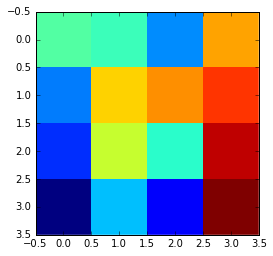

In [5]:
# let's take just a random example
example_i = np.expand_dims(X_unlabel_train[0], 0)

# get the activation of second convolutional layer for this example
activation_i = get_activations([example_i, 0])

# show activation
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(np.squeeze(activation_i)[0], interpolation='none')
plt.show()
